## Week 6 - Ensemble Methods - Bagging, Boosting and Random Forest

In the last lab, we discussed Decision Trees which form the basis for Ensemble Methods like Random Forest. This session, we delve into Ensemble Methods, a set of powerful techniques that combine the predictions of multiple models to improve overall performance. These methods are particularly effective in reducing overfitting, increasing robustness, and enhancing predictive accuracy. We will focus on three key ensemble techniques: Bagging, Boosting, and Random Forest.

In this lab we will continue building on the understanding the tidymodels() directly leveraging the datasets associated with this topic on the ISLR Textbook. The dataset is Boston from the MASS package. For your convenience, the dataset is also available in the folder.

### Loading and Preparing the Dataset

Let's begin by loading and preparing the dataset with some simple basic steps. We won't perform any data preprocessing for this task but instead focus on the technical implementation of the ensemble techniques. Recall that this is the boston housing dataset

In [1]:
library(tidymodels, quietly = TRUE)
library(tidyverse, quietly = TRUE)
library(rpart.plot, quietly = TRUE)
library(vip, quietly = TRUE)   # View of the ranked feature importance
library(ggthemr)
library(gt)

# setting the theme for the notebook
ggthemr("dust")

data("Boston", package = "MASS")
boston <- as_tibble(Boston)

boston %>% slice_head(n = 10)

-- Attaching packages -------------------------------------- tidymodels 1.2.0 --

v broom        1.0.7     v recipes      1.1.0
v dials        1.3.0     v rsample      1.2.1
v dplyr        1.1.4     v tibble       3.2.1
v ggplot2      3.5.1     v tidyr        1.3.1
v infer        1.0.7     v tune         1.2.1
v modeldata    1.4.0     v workflows    1.1.4
v parsnip      1.2.1     v workflowsets 1.1.0
v purrr        1.0.2     v yardstick    1.3.1

-- Conflicts ----------------------------------------- tidymodels_conflicts() --
x purrr::discard() masks scales::discard()
x dplyr::filter()  masks stats::filter()
x dplyr::lag()     masks stats::lag()
x recipes::step()  masks stats::step()
* Learn how to get started at https://www.tidymodels.org/start/

-- Attaching core tidyverse packages ------------------------ tidyverse 2.0.0 --
v forcats   1.0.0     v readr     2.1.5
v lubridate 1.9.3     v stringr   1.5.1
-- Conflicts ------------------------------------------ tidyverse_conflicts() --


crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,black,lstat,medv
<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2
0.02985,0.0,2.18,0,0.458,6.430,58.7,6.0622,3,222,18.7,394.12,5.21,28.7
0.08829,12.5,7.87,0,0.524,6.012,66.6,5.5605,5,311,15.2,395.60,12.43,22.9
0.14455,12.5,7.87,0,0.524,6.172,96.1,5.9505,5,311,15.2,396.90,19.15,27.1
0.21124,12.5,7.87,0,0.524,5.631,100.0,6.0821,5,311,15.2,386.63,29.93,16.5


### Preparing the Dataset

As we have done in many occassions, we will implement a test and train splitting of the dataset. We will then fit the model on the training set and evaluate it on the test set.

In [2]:
data_split <- initial_split(boston, strata = "medv", prop = .8)

train_data <- training(data_split)
test_data <- testing(data_split)

dim(train_data); dim(test_data)

[1] 403  14

[1] 103  14

## Bagging - Bootstrap Aggregating

Bagging is an ensemble technique that improves the stability and accuracy of machine learning algorithms by reducing variance. The basic idea behind bagging is to train multiple instances of a model on different bootstrap samples of the original dataset, and then aggregate their predictions.

__Bootstrap Sampling__: This involves creating multiple datasets by sampling with replacement from the original dataset. Each bootstrap sample is used to train a separate model.

__Model Averaging__: For regression, the predictions from each model are averaged, while for classification, the most common class (majority vote) is selected.

Bagging works particularly well with high-variance models, such as decision trees, by smoothing out their predictions and making the final model more robust.

### Defining the Bagging Model

In this course, we have focused entirely on building models using tidymodels. In particular, we always define the model specification and then fit the model. Our task is regression using Bagging model. We will leverage the randomForest package for the implementation. You may need to install it.

In [3]:
# random forest specificaiont
bagging_spec <- rand_forest(  mtry = .cols() ) %>%   # sample all columns
                set_engine("randomForest", importance = TRUE) %>%
                set_mode("regression")

With the model specification defined, we can now train the model to the train dataset and see how it performs.

In [4]:
bagging_fit <- fit(bagging_spec, medv ~ ., data = train_data)

In [5]:
augment( bagging_fit, new_data = train_data ) %>%
    rmse( truth = medv, estimate = .pred )

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rmse,standard,1.468931


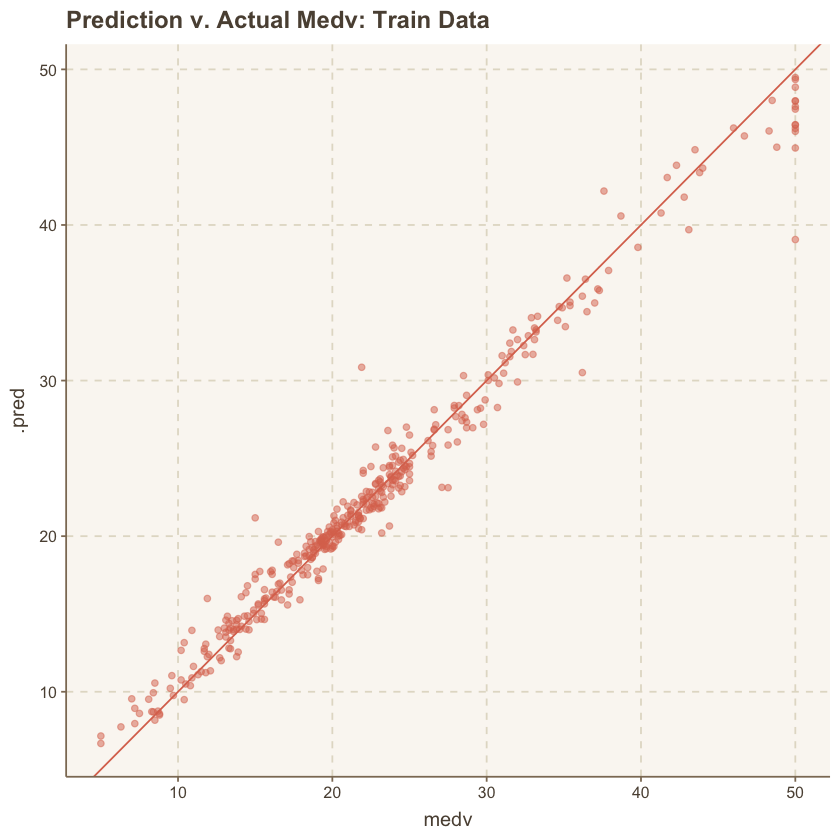

In [6]:
augment( bagging_fit, new_data = train_data ) %>%
    ggplot( aes(medv, .pred)) + 
        geom_abline() +
        geom_point(alpha = .5) +
        ggtitle("Prediction v. Actual Medv: Train Data")

The performance of our model is quite good on the test set with a very low rmse. Now, let's see how it performs on the test data.

In [7]:
augment( bagging_fit, new_data = test_data ) %>%
    rmse( truth = medv, estimate = .pred )

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rmse,standard,2.546312


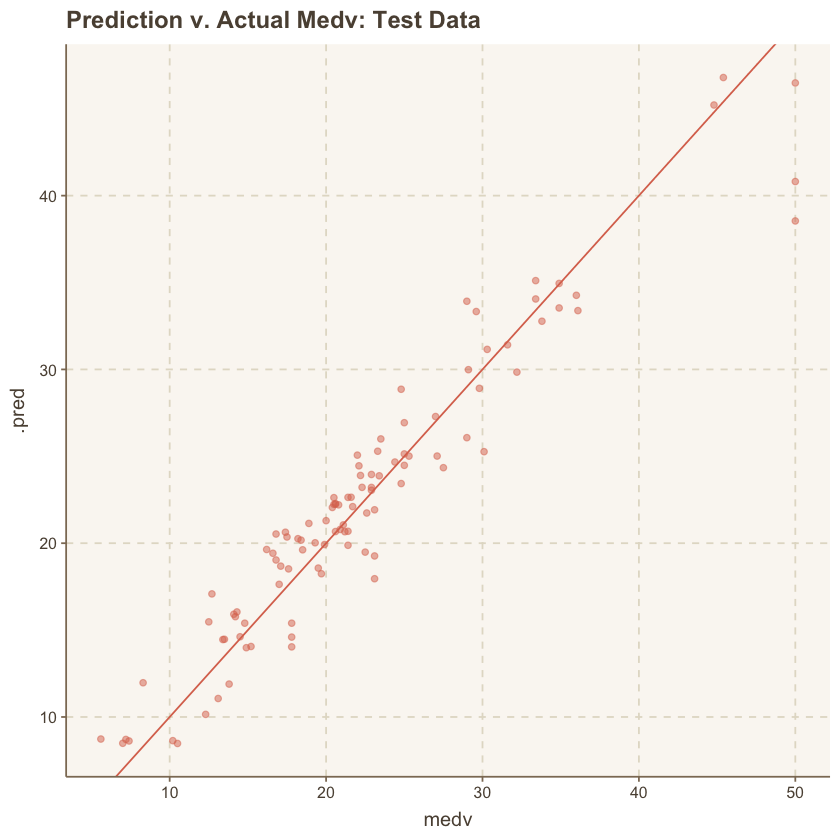

In [8]:
# visualizing the predictions
augment( bagging_fit, new_data = test_data ) %>%
    ggplot( aes(medv, .pred)) + 
        geom_abline() +
        geom_point(alpha = .5) +
        ggtitle("Prediction v. Actual Medv: Test Data")

Inspecting the prediction on the test set visually, we see that our model performs quite decently. In the previous labs, we have explored how to get regression performance metrics. Implement those steps to get the metrics for this model.

### Variable Importance

Like classical regression methods, we can look at the usefulness of the features and their predictive importance. While we can't do it the same way, say using p-values, we can use the vip package to return the visualization of the ordered feature importance of the model. We simply pass the model fit object and we get the feature importance ranking.

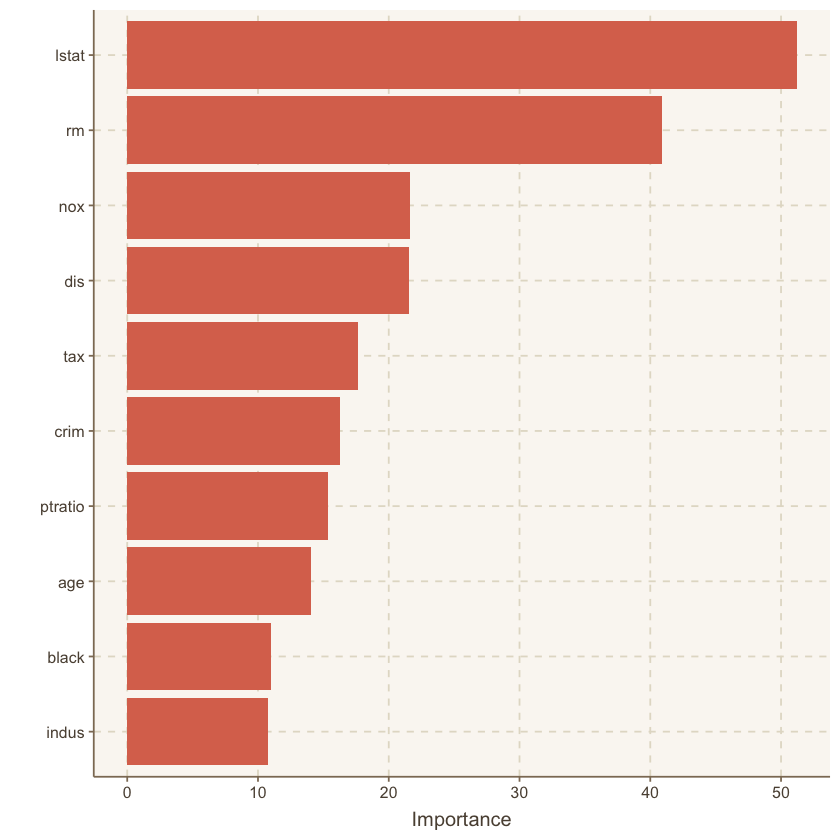

In [9]:
vip(bagging_fit)

We have broadly demonstrated boosting. Now, we will specifically looking at Random Forest.

### Random Forest

Random Forest is a machine learning technique that uses an ensemble of decision trees to make decision. Effectively, random forest is generated from a running different decision trees from random samples of the data. This ensures that each decision tree may capture specific attributes that may reduce bias and some not, and in consequence, the collection/ensemble of these trees will reduce overfitting that is often a weakness of decision trees.

### Defining the Random Forest Model

In [10]:
random_forest <- rand_forest( mtry = 6 ) %>%   # mtry: Number of variables to try with each sampling
                 set_engine("randomForest", importance = TRUE) %>%
                 set_mode("regression")

random_forest

Random Forest Model Specification (regression)

Main Arguments:
  mtry = 6

Engine-Specific Arguments:
  importance = TRUE

Computational engine: randomForest 


In [11]:
random_forest_fit <- fit( random_forest, formula = medv ~ ., data = train_data)

random_forest_fit

parsnip model object


Call:
 randomForest(x = maybe_data_frame(x), y = y, mtry = min_cols(~6,      x), importance = ~TRUE) 
               Type of random forest: regression
                     Number of trees: 500
No. of variables tried at each split: 6

          Mean of squared residuals: 11.80243
                    % Var explained: 86.3

In [12]:
augment(random_forest_fit, new_data = train_data) %>%
  rmse(truth = medv, estimate = .pred)

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rmse,standard,1.464924


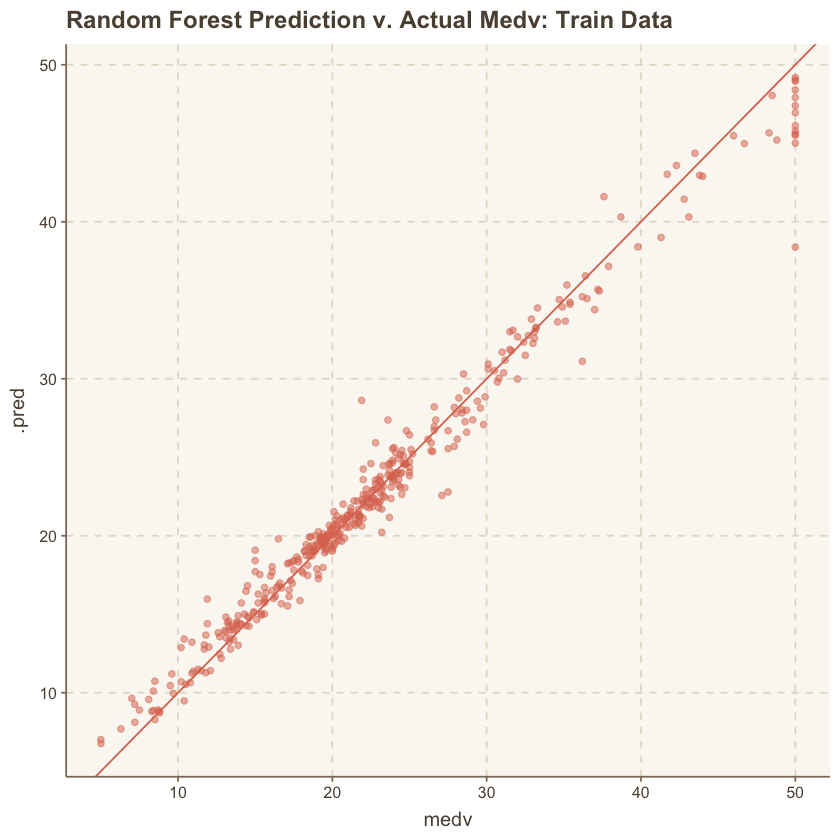

In [13]:
augment( random_forest_fit, new_data = train_data ) %>%
    ggplot( aes(medv, .pred)) + 
        geom_abline() +
        geom_point(alpha = .5) +
        ggtitle("Random Forest Prediction v. Actual Medv: Train Data")

The model performs very well, similar to our base boosting model.

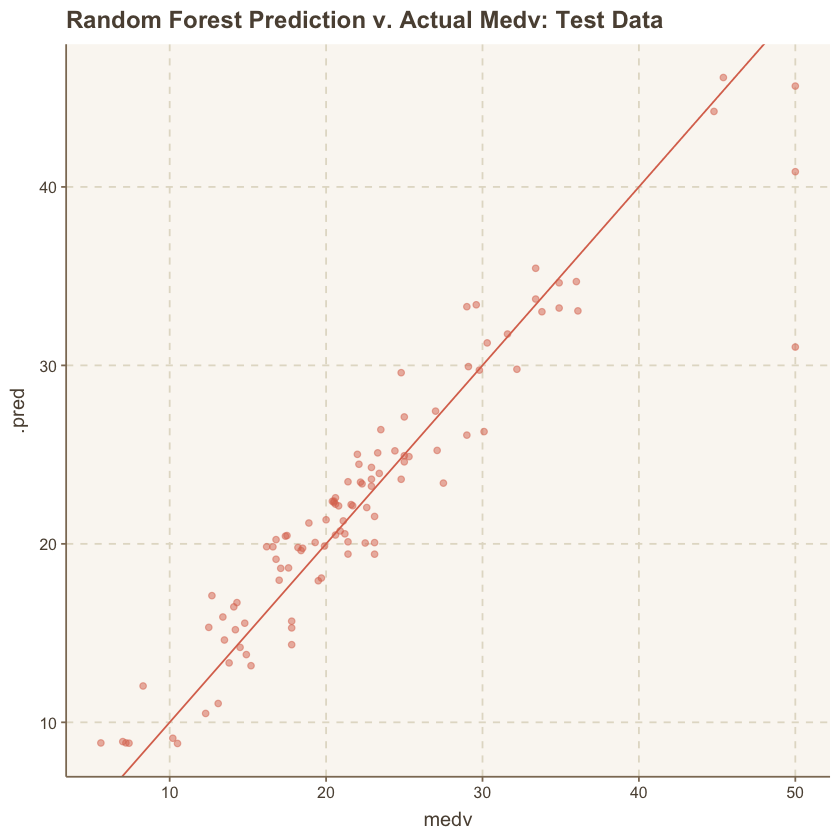

In [14]:
augment( random_forest_fit, new_data = test_data ) %>%
    ggplot( aes(medv, .pred)) + 
        geom_abline() +
        geom_point(alpha = .5) +
        ggtitle("Random Forest Prediction v. Actual Medv: Test Data")

In [15]:
augment(random_forest_fit, new_data = test_data) %>%
  rmse(truth = medv, estimate = .pred)

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rmse,standard,2.941629


We notice a slight improvement from bagging model on $rsme$ as compared to random forest fit. Broadly, both models perform nearly the same and correctly so because they are implementing very similar approaches.

### Variable Importance Features

We can also get variable importance as we did with boosting model using the same function vip.

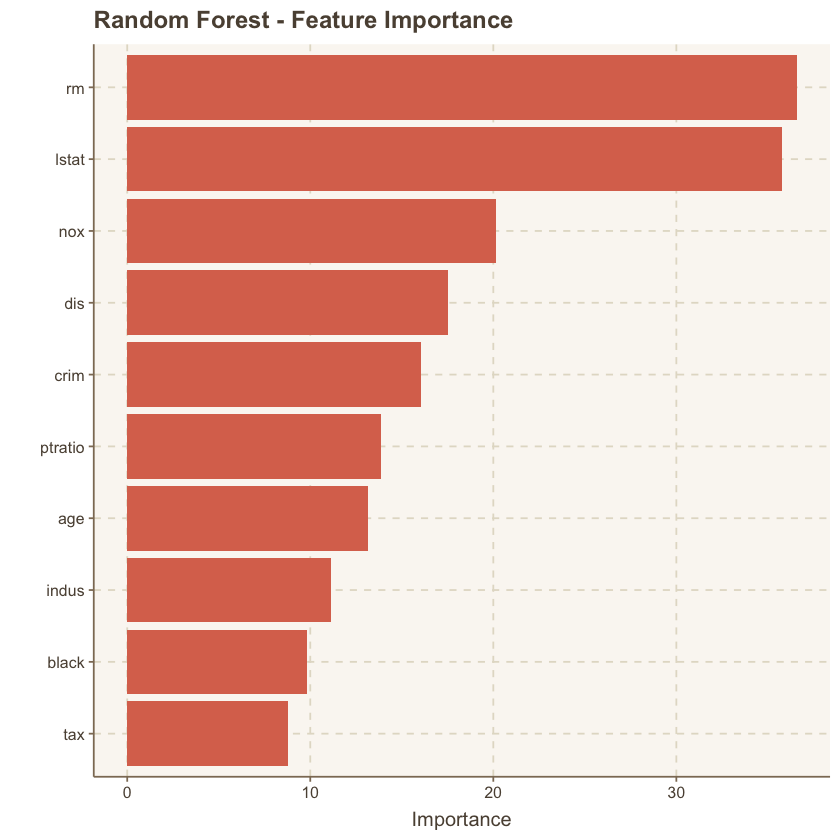

In [16]:
vip(random_forest_fit, ) + ggtitle("Random Forest - Feature Importance")

Note that the importance value and ranking with random forest and boosting models earlier are different and variables have shifted in position. Example, variables age and nox has shifted in importance and their respective magnitude as well.

### Boosting

Boosting is an ensemble technique that aims to improve learning by sequentially training week learners, focusing on incorrect predictions in order to improve them. This happens by assigning higher weights to mis-classified or wrong predictions which then forces the sequential models to pay attention to these features. The combination of all these models ultimately leads to a final model with low bias.

Let's now see the implementation of this in tidymodels. Note that for boosting, we will need the package xgboost.

In [17]:
boost_spec <- boost_tree( trees = 5000, tree_depth = 4 ) %>%
              set_engine("xgboost") %>%
              set_mode("regression")

In [18]:
boost_fit <- fit(boost_spec, formula = medv ~ ., data = train_data )

### Assessing the Model Outcome

At this point, training and fitting the model should feel very pedestrian. With the model in hand, we can look at the performance of the model to determine how it did. We first look at the training set.

In [19]:
augment(boost_fit, new_data = train_data) %>%
  rmse(truth = medv, estimate = .pred)

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rmse,standard,0.001464333


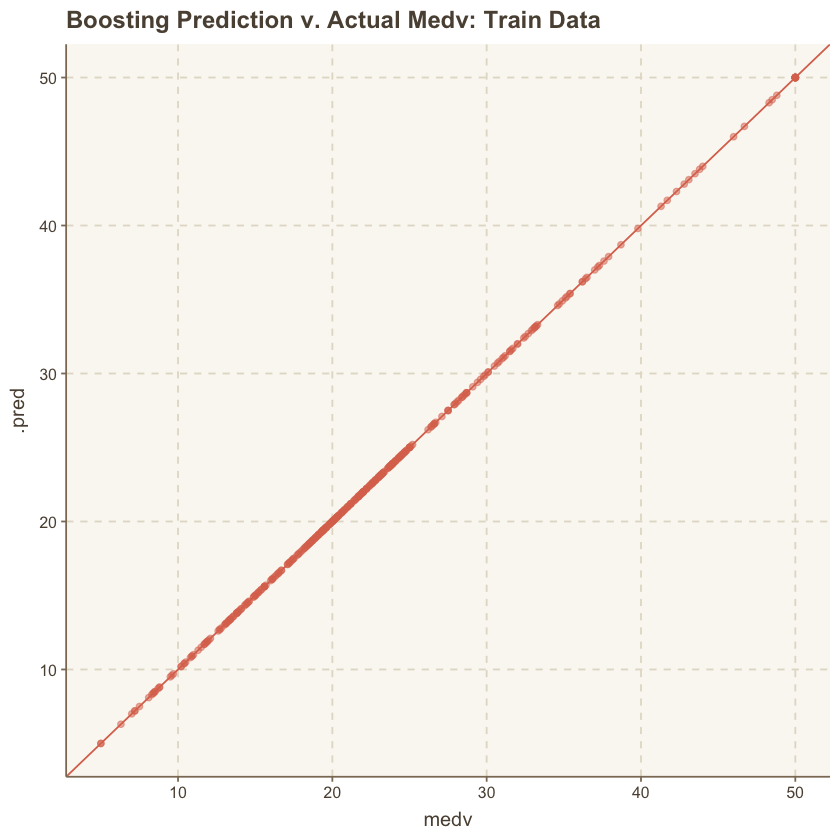

In [20]:
augment(boost_fit, new_data = train_data) %>%
  ggplot(aes(medv, .pred)) +
  geom_abline() +
  geom_point(alpha = 0.5) +
  ggtitle("Boosting Prediction v. Actual Medv: Train Data")

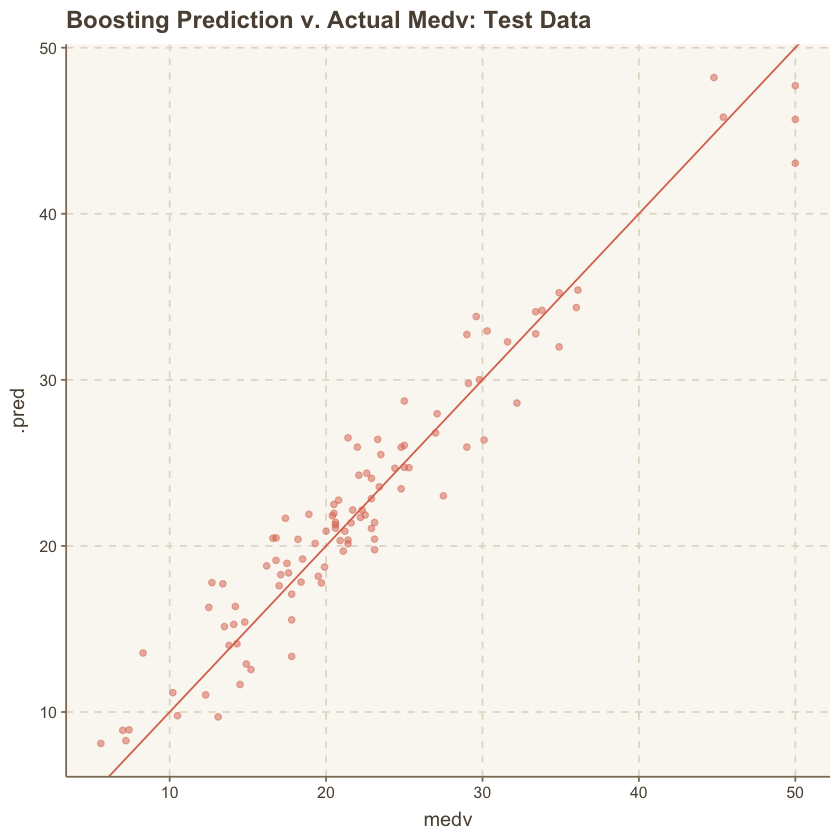

In [21]:
augment(boost_fit, new_data = test_data) %>%
  ggplot(aes(medv, .pred)) +
  geom_abline() +
  geom_point(alpha = 0.5) +
  ggtitle("Boosting Prediction v. Actual Medv: Test Data")

In [22]:
augment(boost_fit, new_data = test_data) %>%
  rmse(truth = medv, estimate = .pred)

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rmse,standard,2.363368


On both the training and the testing set, the performance of the model is very good, better than the performance on the random forest model. Finally, we can look at the variable importance plot.

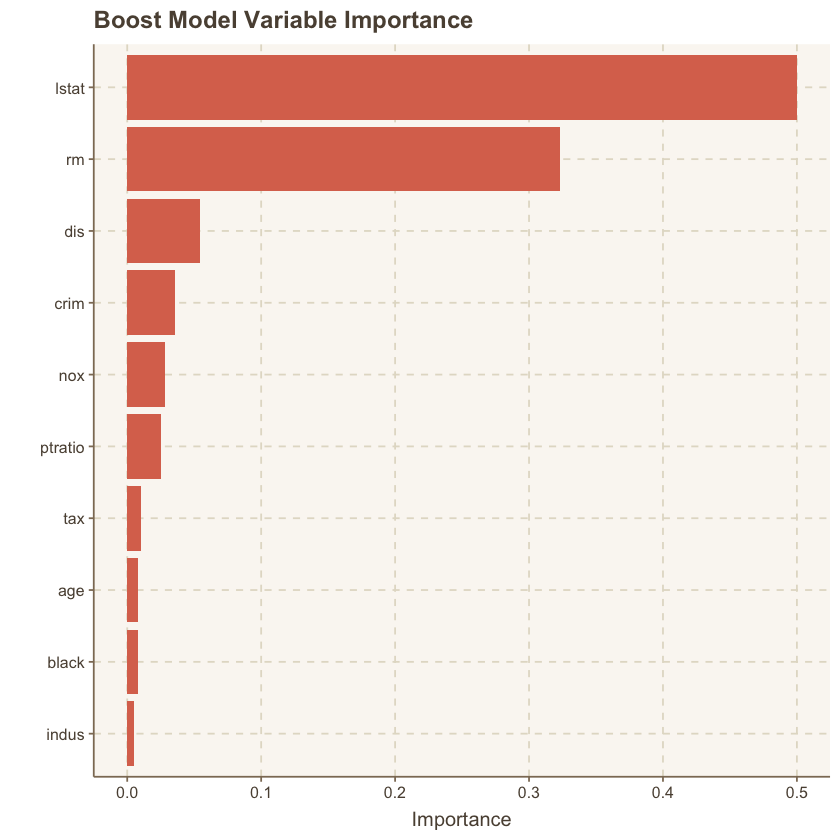

In [23]:
vip(boost_fit) + ggtitle("Boost Model Variable Importance")

The boosting model offers a very different picture to what variables it considers important for prediction. For example, crim has moved up in importance compared to the other two models. Also notice that the scale is different.

This now concludes the practical implementation of the ensemble methods for this lab.

## References:

1. VIP Tool: https://koalaverse.github.io/vip/articles/vip.html
2. Ensemble Methods in tidymodels: https://emilhvitfeldt.github.io/ISLR-tidymodels-labs/08-tree-based-methods.html

